In [30]:
import numpy as np 
import pandas as pd 
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, BertModel
from flask import Flask, request, jsonify
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt


Data visualization 

In [21]:
pd.read_csv('/Users/maithilibhuyar/Desktop/Precily_Task/Precily_Text_Similarity.csv')

,text1,text2
0,broadband challenges tv viewing the number of ...,gardener wins double in glasgow britain s jaso...
1,rap boss arrested over drug find rap mogul mar...,amnesty chief laments war failure the lack of ...
2,player burn-out worries robinson england coach...,hanks greeted at wintry premiere hollywood sta...
3,hearts of oak 3-2 cotonsport hearts of oak set...,redford s vision of sundance despite sporting ...
4,sir paul rocks super bowl crowds sir paul mcca...,mauresmo opens with victory in la amelie maure...
...,...,...
2995,uk directors guild nominees named martin scors...,steel firm to cut 45 000 jobs mittal steel ...
2996,u2 to play at grammy awards show irish rock ba...,israel looks to us for bank chief israel has a...
2997,pountney handed ban and fine northampton coach...,india and iran in gas export deal india has si...
2998,belle named best scottish band belle & sebas...,mido makes third apology ahmed mido hossam h...


In [15]:
import nltk

# Download all required NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maithilibhuyar/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maithilibhuyar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Data preprocessing 


In [18]:

# Load the dataset from the CSV file
dataset_path = '/Users/maithilibhuyar/Desktop/Precily_Task/Precily_Text_Similarity.csv'
df = pd.read_csv(dataset_path)

# Data Preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation tokens
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming (optional)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back to form the processed text
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to both 'text1' and 'text2' columns
df['text1'] = df['text1'].apply(preprocess_text)
df['text2'] = df['text2'].apply(preprocess_text)

# Display the preprocessed DataFrame
print(df.head())



                                               text1  \
0  broadband challeng tv view number european bro...   
1  rap boss arrest drug find rap mogul marion sug...   
2  player burnout worri robinson england coach an...   
3  heart oak 32 cotonsport heart oak set ghanaian...   
4  sir paul rock super bowl crowd sir paul mccart...   

                                               text2  
0  garden win doubl glasgow britain jason garden ...  
1  amnesti chief lament war failur lack public ou...  
2  hank greet wintri premier hollywood star tom h...  
3  redford vision sundanc despit sport corduroy c...  
4  mauresmo open victori la ameli mauresmo maria ...  


Embeddings 

In [22]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to encode text paragraphs into embeddings
def encode_text(text):
    # Tokenize the text and convert to tensors
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # Pass the inputs through the model to get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings from the model outputs
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return embeddings

# Encode 'text1' and 'text2' columns into embeddings
df['text1_embeddings'] = df['text1'].apply(encode_text)
df['text2_embeddings'] = df['text2'].apply(encode_text)

# Display the DataFrame with embeddings
print(df.head())

                                               text1  \
0  broadband challeng tv view number european bro...   
1  rap boss arrest drug find rap mogul marion sug...   
2  player burnout worri robinson england coach an...   
3  heart oak 32 cotonsport heart oak set ghanaian...   
4  sir paul rock super bowl crowd sir paul mccart...   

                                               text2  \
0  garden win doubl glasgow britain jason garden ...   
1  amnesti chief lament war failur lack public ou...   
2  hank greet wintri premier hollywood star tom h...   
3  redford vision sundanc despit sport corduroy c...   
4  mauresmo open victori la ameli mauresmo maria ...   

                                    text1_embeddings  \
0  [[-0.25395882, 0.016762383, 0.43942404, -0.007...   
1  [[-0.45068353, 0.01692449, 0.10169643, -0.0568...   
2  [[-0.47159213, -0.10603104, 0.26686823, -0.082...   
3  [[-0.43389314, -0.055328753, 0.046310127, -0.0...   
4  [[-0.36103565, -0.31523117, 0.31159514, 0.2

Semantic similarity 

In [26]:
# Function to calculate cosine similarity
def calculate_cosine_similarity(embeddings1, embeddings2):
    # Calculate cosine similarity between the embeddings
    similarity_score = cosine_similarity(embeddings1.reshape(1, -1), embeddings2.reshape(1, -1))[0][0]
    return similarity_score

# Apply cosine similarity to the DataFrame and create a new column 'similarity_score'
df['similarity_score'] = df.apply(lambda row: calculate_cosine_similarity(row['text1_embeddings'], row['text2_embeddings']), axis=1)

# Display the DataFrame with the similarity scores
print(df.head())

                                               text1  \
0  broadband challeng tv view number european bro...   
1  rap boss arrest drug find rap mogul marion sug...   
2  player burnout worri robinson england coach an...   
3  heart oak 32 cotonsport heart oak set ghanaian...   
4  sir paul rock super bowl crowd sir paul mccart...   

                                               text2  \
0  garden win doubl glasgow britain jason garden ...   
1  amnesti chief lament war failur lack public ou...   
2  hank greet wintri premier hollywood star tom h...   
3  redford vision sundanc despit sport corduroy c...   
4  mauresmo open victori la ameli mauresmo maria ...   

                                    text1_embeddings  \
0  [[-0.25395882, 0.016762383, 0.43942404, -0.007...   
1  [[-0.45068353, 0.01692449, 0.10169643, -0.0568...   
2  [[-0.47159213, -0.10603104, 0.26686823, -0.082...   
3  [[-0.43389314, -0.055328753, 0.046310127, -0.0...   
4  [[-0.36103565, -0.31523117, 0.31159514, 0.2

**Testing accuracy**

In [27]:

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Separate features and target for training set
train_text1_embeddings = np.vstack(train_df['text1_embeddings'].values)
train_text2_embeddings = np.vstack(train_df['text2_embeddings'].values)
train_similarity_scores = train_df['similarity_score'].values

# Separate features and target for validation set
val_text1_embeddings = np.vstack(val_df['text1_embeddings'].values)
val_text2_embeddings = np.vstack(val_df['text2_embeddings'].values)
val_similarity_scores = val_df['similarity_score'].values

# Display the shapes of training and validation sets
print("Training set shape:")
print("Text1 embeddings:", train_text1_embeddings.shape)
print("Text2 embeddings:", train_text2_embeddings.shape)
print("Similarity scores:", train_similarity_scores.shape)

print("\nValidation set shape:")
print("Text1 embeddings:", val_text1_embeddings.shape)
print("Text2 embeddings:", val_text2_embeddings.shape)
print("Similarity scores:", val_similarity_scores.shape)


Training set shape:
Text1 embeddings: (2400, 768)
Text2 embeddings: (2400, 768)
Similarity scores: (2400,)

Validation set shape:
Text1 embeddings: (600, 768)
Text2 embeddings: (600, 768)
Similarity scores: (600,)


Graphs


/var/folders/0r/klw0gtf17vbds0klb5xl3wnw0000gn/T/ipykernel_9472/1288658970.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['similarity_score'], shade=True, color='blue')


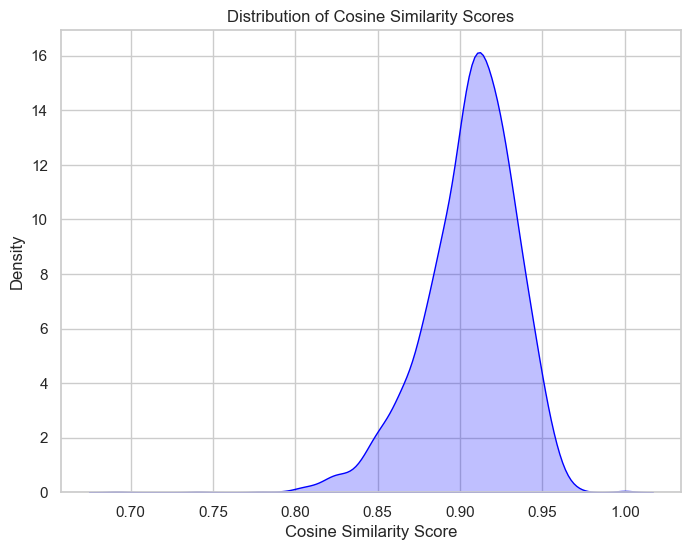

In [29]:
# Plot the distribution of cosine similarity scores using a kernel density plot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.kdeplot(df['similarity_score'], shade=True, color='blue')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.title('Distribution of Cosine Similarity Scores')
plt.show()

Testing API

In [ ]:
import requests

# Replace 'http://example-api.com' with the actual URL of your deployed API endpoint
api_endpoint = 'http://example-api.com'

# Test data: text pairs to be compared
text_pair_1 = {
    'text1': 'The quick brown fox jumps over the lazy dog.',
    'text2': 'A fast brown fox jumps over a lazy dog.'
}

text_pair_2 = {
    'text1': 'This is a test sentence.',
    'text2': 'This is a sample sentence.'
}

# Send POST request to the API endpoint and get the similarity scores as responses
response_1 = requests.post(api_endpoint, json=text_pair_1)
response_2 = requests.post(api_endpoint, json=text_pair_2)

# Extract similarity scores from the responses
similarity_score_1 = response_1.json()['similarity_score']
similarity_score_2 = response_2.json()['similarity_score']

# Display the similarity scores
print('Similarity Score 1:', similarity_score_1)
print('Similarity Score 2:', similarity_score_2)
